In [2]:
%cd ../

/Users/kevinhe/Documents/UHN/Projects/model-deployer


In [3]:
import pandas as pd
from deployer.data_prep.preprocess.emergency import get_emergency_room_data
from deployer.loader import Config, Model
from deployer.monthly_model_eval import get_patients_with_completed_trt
from make_clinical_dataset.epr.label import get_ED_labels

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [4]:
config = Config(info_dir="./Infos")

# Treatment Anchored

In [5]:
model = Model(model_dir="./Models", prep_dir="./Infos/Train_Data_parameters", anchor="treatment")

In [8]:
input_df = pd.read_parquet("./Outputs/input_treatment.parquet")
output_df = pd.read_csv("./Outputs/output_treatment.csv", parse_dates=["treatment_date"])
output_df["assessment_date"] = output_df["treatment_date"]
output_df["last_seen_date"] = pd.Timestamp.max

df = pd.concat([output_df, input_df], axis=1)
df["month_year"] = df["assessment_date"].dt.to_period("M")

ed_visit = get_emergency_room_data("./Data/AIM2REDUCE_ED_visits_monthly_20250404.csv", anchor="")
df = get_ED_labels(df, ed_visit, lookahead_window=31)

# filter out cases where ED visit occurred on the same day
df = df[(df["target_ED_date"] - df["assessment_date"]).dt.days != 0]

# sort patients only with completed treatments during the month
chemo_file = "./Data/AIM2REDUCE_chemo_monthly_20250404.csv"
df = get_patients_with_completed_trt(
    config, chemo_file, start_date="20240904", end_date="20250404", df=df, anchor="treatment"
)

In [21]:
df.groupby("month_year")["target_ED_31d"].value_counts().unstack().T

month_year,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04
target_ED_31d,,,,,,,,
False,494.0,635.0,655.0,588.0,683.0,618.0,687.0,114.0
True,41.0,60.0,55.0,60.0,69.0,70.0,55.0,NaN


In [22]:
# New Results
from sklearn.metrics import roc_auc_score

res = {}
for month_year, group in df.groupby("month_year"):
    label = group["target_ED_31d"]
    if label.nunique() == 1:
        continue
    pred = group["ed_pred_prob"]
    res[month_year] = roc_auc_score(label, pred)
pd.DataFrame({"AUROC": res})

,AUROC
2024-09,0.828478
2024-10,0.810118
2024-11,0.719972
2024-12,0.703656
2025-01,0.709519
2025-02,0.752577
2025-03,0.693463


In [ ]:
# Old Results
from sklearn.metrics import roc_auc_score

res = {}
for month_year, group in df.groupby("month_year"):
    label = group["target_ED_31d"]
    if label.nunique() == 1:
        continue
    pred = group["ed_pred_prob"]
    res[month_year] = roc_auc_score(label, pred)
pd.DataFrame({"AUROC": res})

,AUROC
2024-09,0.827614
2024-10,0.806312
2024-11,0.722082
2024-12,0.706944
2025-01,0.708394
2025-02,0.752369
2025-03,0.697684


# Clinic Anchored

In [5]:
model = Model(model_dir="./Models", prep_dir="./Infos/Train_Data_parameters", anchor="clinic")

In [7]:
input_df = pd.read_parquet("./Outputs/input_clinic.parquet")
output_df = pd.read_csv("./Outputs/output_clinic.csv", parse_dates=["clinic_date"])
output_df["assessment_date"] = output_df["clinic_date"]
output_df["last_seen_date"] = pd.Timestamp.max

df = pd.concat([output_df, input_df], axis=1)
df["month_year"] = df["assessment_date"].dt.to_period("M")

ed_visit = get_emergency_room_data("./Data/AIM2REDUCE_ED_visits_monthly_20250404.csv")
df = get_ED_labels(df, ed_visit, lookahead_window=31)

# filter out cases where ED visit occurred on the same day
df = df[(df["target_ED_date"] - df["clinic_date"]).dt.days != 0]

# sort patients only with completed treatments during the month
chemo_file = "./Data/AIM2REDUCE_chemo_monthly_20250404.csv"
df = get_patients_with_completed_trt(
    config, chemo_file, start_date="20240904", end_date="20250404", df=df, anchor="treatment"
)

In [25]:
df.groupby("month_year")["target_ED_31d"].value_counts().unstack().T

month_year,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04
target_ED_31d,,,,,,,,
False,300.0,406.0,385.0,322.0,367.0,333.0,383.0,76.0
True,26.0,28.0,27.0,36.0,31.0,36.0,31.0,NaN


In [26]:
# New results after changing the primary site encoding scheme (July 18 2025)
from sklearn.metrics import roc_auc_score

res = {}
for month_year, group in df.groupby("month_year"):
    label = group["target_ED_31d"]
    if label.nunique() == 1:
        continue
    pred = group["ed_pred_prob"]
    res[month_year] = roc_auc_score(label, pred)
res = pd.DataFrame({"AUROC": res})
print(res.mean())
res

AUROC    0.72926
dtype: float64


,AUROC
2024-09,0.775385
2024-10,0.740060
2024-11,0.732708
2024-12,0.747326
2025-01,0.701723
2025-02,0.650567
2025-03,0.757054


In [ ]:
# Old results
from sklearn.metrics import roc_auc_score

res = {}
for month_year, group in df.groupby("month_year"):
    label = group["target_ED_31d"]
    if label.nunique() == 1:
        continue
    pred = group["ed_pred_prob"]
    res[month_year] = roc_auc_score(label, pred)
pd.DataFrame({"AUROC": res})

,AUROC
2024-09,0.777500
2024-10,0.729108
2024-11,0.734584
2024-12,0.745816
2025-01,0.688011
2025-02,0.652444
2025-03,0.755580


In [27]:
from ml_common.eval import get_perf_at_operating_point

res = {}
for month_year, group in df.groupby("month_year"):
    if group["target_ED_date"].isna().all():
        continue
    perf = get_perf_at_operating_point(
        df=group,
        targ_col="target_ED_31d",
        pred_col="ed_pred_prob",
        threshold=0.160,
        lookahead_window=30,
        main_date_col="assessment_date",
        event_date_col="target_ED_date",
    )
    res[month_year] = perf
res = pd.DataFrame(res).round(3)
print(res.mean(axis=1))
res

Threshold                0.160000
Warning rate             0.192857
First-alarm precision    0.190429
Outcome-level recall     0.481286
Accuracy                 0.803000
Precision                0.193714
Recall                   0.473429
Specificity              0.831714
NPV                      0.948000
FPR                      0.168286
FNR                      0.526571
FDR                      0.806286
dtype: float64


,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03
Threshold,0.160,0.160,0.160,0.160,0.160,0.160,0.160
Warning rate,0.221,0.200,0.150,0.204,0.186,0.179,0.210
First-alarm precision,0.226,0.175,0.136,0.296,0.135,0.143,0.222
Outcome-level recall,0.652,0.560,0.429,0.562,0.333,0.300,0.533
Accuracy,0.804,0.804,0.833,0.813,0.781,0.789,0.797
Precision,0.236,0.172,0.161,0.288,0.122,0.182,0.195
Recall,0.654,0.536,0.370,0.583,0.290,0.333,0.548
Specificity,0.817,0.823,0.865,0.839,0.823,0.838,0.817
NPV,0.965,0.963,0.951,0.947,0.932,0.921,0.957
FPR,0.183,0.177,0.135,0.161,0.177,0.162,0.183


# Scratch Notes

## All Months 

In [ ]:
!python src/main.py --start-date 20240904 --end-date 20250804 --model-anchor clinic
!python src/monthly_model_eval.py --model-anchor clinic --monthly-pull-date 20250604 --start-date 20240904 --end-date 20250804

In [4]:
ed_visit = get_emergency_room_data("./Data/AIM2REDUCE_ED_visits_monthly_20250804.csv", anchor="")
input_df = pd.read_parquet("./Outputs/input_clinic.parquet")
output_df = pd.read_csv("./Outputs/output_clinic.csv", parse_dates=["clinic_date"])
output_df["assessment_date"] = output_df["clinic_date"]
output_df["month_year"] = output_df["assessment_date"].dt.to_period("M")
df = pd.concat([output_df, input_df], axis=1)
df = get_ED_labels(df, ed_visit, lookahead_window=31)
df = df[(df["target_ED_date"] - df["clinic_date"]).dt.days != 0]
df = get_patients_with_completed_trt(
    config,
    "./Data/AIM2REDUCE_chemo_monthly_20250804.csv",
    start_date="20240904",
    end_date="20250804",
    df=df,
    anchor="treatment",
)

In [5]:
from sklearn.metrics import roc_auc_score

res = {}
for month_year, group in df.groupby("month_year"):
    label = group["target_ED_31d"]
    if label.nunique() == 1:
        continue
    pred = group["ed_pred_prob"]
    res[month_year] = roc_auc_score(label, pred)
res = pd.DataFrame({"AUROC": res})
print(res.mean())
res

AUROC    0.730028
dtype: float64


,AUROC
2024-09,0.775344
2024-10,0.740060
2024-11,0.732708
2024-12,0.747326
2025-01,0.701723
2025-02,0.650567
2025-03,0.729498
2025-04,0.674929
2025-05,0.751294
2025-06,0.825851


In [57]:
from ml_common.eval import get_perf_at_operating_point

res = {}
for month_year, group in df.groupby("month_year"):
    if group["target_ED_date"].isna().all():
        continue
    perf = get_perf_at_operating_point(
        df=group,
        targ_col="target_ED_31d",
        pred_col="ed_pred_prob",
        threshold=0.160,
        lookahead_window=30,
        main_date_col="assessment_date",
        event_date_col="target_ED_date",
    )
    res[month_year] = perf
res = pd.DataFrame(res).round(3)
print(res.mean(axis=1))
res

Threshold                0.160000
Warning rate             0.193273
First-alarm precision    0.184091
Outcome-level recall     0.492455
Accuracy                 0.802727
Precision                0.189364
Recall                   0.475000
Specificity              0.830455
NPV                      0.949364
FPR                      0.169545
FNR                      0.525000
FDR                      0.810636
dtype: float64


,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
Threshold,0.160,0.160,0.160,0.160,0.160,0.160,0.160,0.160,0.160,0.160,0.160
Warning rate,0.220,0.200,0.150,0.204,0.186,0.179,0.212,0.165,0.196,0.195,0.219
First-alarm precision,0.226,0.175,0.136,0.296,0.135,0.143,0.250,0.196,0.118,0.207,0.143
Outcome-level recall,0.652,0.560,0.429,0.562,0.333,0.300,0.512,0.433,0.375,0.682,0.579
Accuracy,0.805,0.804,0.833,0.813,0.781,0.789,0.788,0.826,0.786,0.830,0.775
Precision,0.236,0.172,0.161,0.288,0.122,0.182,0.261,0.214,0.130,0.212,0.105
Recall,0.654,0.536,0.370,0.583,0.290,0.333,0.500,0.441,0.370,0.708,0.440
Specificity,0.818,0.823,0.865,0.839,0.823,0.838,0.824,0.859,0.816,0.837,0.793
NPV,0.965,0.963,0.951,0.947,0.932,0.921,0.930,0.946,0.946,0.979,0.963
FPR,0.182,0.177,0.135,0.161,0.177,0.162,0.176,0.141,0.184,0.163,0.207


In [7]:
df.groupby("month_year")["target_ED_31d"].value_counts().unstack().T

month_year,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08
target_ED_31d,,,,,,,,,,,,
False,302.0,406.0,385.0,322.0,367.0,333.0,369.0,391.0,365.0,387.0,454.0,24.0
True,26.0,28.0,27.0,36.0,31.0,36.0,46.0,34.0,27.0,24.0,25.0,NaN


In [8]:
print(df["mrn"].nunique())
df.groupby("month_year")["mrn"].nunique()

730


month_year
2024-09    241
2024-10    289
2024-11    284
2024-12    271
2025-01    272
2025-02    275
2025-03    297
2025-04    297
2025-05    276
2025-06    286
2025-07    320
2025-08     24
Freq: M, Name: mrn, dtype: int64

In [54]:
# Ref: https://towardsdatascience.com/pooled-roc-with-xgboost-and-plotly-553a8169680c/
import numpy as np
from plotly import graph_objects as go
from sklearn.metrics import roc_curve

c_line = "rgba(52, 152, 219, 0.5)"
c_line_main = "rgba(41, 128, 185, 1.0)"
c_fill = "rgba(52, 152, 219, 0.2)"
c_grid = "rgba(189, 195, 199, 0.5)"

res = {}
for month_year, group in df.groupby("month_year"):
    label = group["target_ED_31d"]
    if label.nunique() == 1:
        continue
    pred = group["ed_pred_prob"]

    fpr, tpr, thresholds = roc_curve(label, pred)
    res[month_year] = {"fpr": fpr, "tpr": tpr, "thresholds": thresholds, "auc": roc_auc_score(label, pred)}

fpr_mean = np.linspace(0, 1, 100)
interp_tprs = []
scatter_objs = []
for month_year, metrics in res.items():
    fpr = metrics["fpr"]
    tpr = metrics["tpr"]
    interp_tpr = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)
    scatter_objs.append(
        go.Scatter(
            x=fpr,
            y=tpr,
            line=dict(color=c_line_main, width=0.2),
            hoverinfo="skip",
            showlegend=False,
            name=str(month_year),
        )
    )
tpr_mean = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std = 2 * np.std(interp_tprs, axis=0)
tpr_upper = np.clip(tpr_mean + tpr_std, 0, 1)
tpr_lower = tpr_mean - tpr_std
aucs = [metrics["auc"] for metrics in res.values()]
auc, auc_min, auc_max = np.mean(aucs), min(aucs), max(aucs)

threshold = 0.16  # 20% alarm rate
idx = int(threshold * 100)

fig = go.Figure(
    [
        go.Scatter(
            x=fpr_mean, y=tpr_upper, line=dict(color=c_line, width=1), hoverinfo="skip", showlegend=False, name="upper"
        ),
        go.Scatter(
            x=fpr_mean,
            y=tpr_lower,
            fill="tonexty",
            fillcolor=c_fill,
            line=dict(color=c_line, width=1),
            hoverinfo="skip",
            showlegend=False,
            name="lower",
        ),
        go.Scatter(
            x=fpr_mean,
            y=tpr_mean,
            line=dict(color=c_line_main, width=2),
            hoverinfo="skip",
            showlegend=True,
            name=f"Overall AUC: {auc:.2f} ({auc_min:.2f} - {auc_max:.2f})",
        ),
        go.Scatter(
            x=[fpr_mean[idx]],
            y=[tpr_mean[idx]],
            mode="markers",
            marker=dict(size=10),
            name=f"Threshold @{threshold}",
            hoverinfo="skip",
            showlegend=True,
        ),
        *scatter_objs,
    ]
)
fig.add_shape(type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1)
fig.update_layout(
    template="plotly_white",
    title_x=0.5,
    xaxis_title="1 - Specificity",
    yaxis_title="Sensitivity",
    width=500,
    height=500,
    legend=dict(yanchor="bottom", xanchor="right", x=0.95, y=0.01),
    margin=dict(l=10, r=10, b=10, t=10),
)
fig.update_yaxes(range=[0, 1], gridcolor=c_grid, scaleanchor="x", scaleratio=1, linecolor="black")
fig.update_xaxes(range=[0, 1], gridcolor=c_grid, constrain="domain", linecolor="black")

fig.write_image("/Users/kevinhe/Downloads/auroc.png", scale=4, width=500, height=500)
fig

04:00:13 INFO:Chromium init'ed with kwargs {}
04:00:13 INFO:Found chromium path: /Applications/Google Chrome.app/Contents/MacOS/Google Chrome
04:00:13 INFO:Temp directory created: /var/folders/z4/8_5mvcb50jb15r8l3sl1qj4m0000gn/T/tmp54h73pul.
04:00:13 INFO:Opening browser.
04:00:13 INFO:Temp directory created: /var/folders/z4/8_5mvcb50jb15r8l3sl1qj4m0000gn/T/tmpxswvfzmr.
04:00:13 INFO:Temporary directory at: /var/folders/z4/8_5mvcb50jb15r8l3sl1qj4m0000gn/T/tmpxswvfzmr
04:00:15 INFO:Conforming 1 to file:///var/folders/z4/8_5mvcb50jb15r8l3sl1qj4m0000gn/T/tmp54h73pul/index.html
04:00:15 INFO:Waiting on all navigates
04:00:15 INFO:All navigates done, putting them all in queue.
04:00:15 INFO:Getting tab from queue (has 1)
04:00:15 INFO:Got 3B72
04:00:15 INFO:Processing fig.png
04:00:15 INFO:Sending big command for fig.png.
04:00:16 INFO:Sent big command for fig.png.
04:00:16 INFO:Reloading tab 3B72 before return.
04:00:16 INFO:Putting tab 3B72 back (queue size: 0).
04:00:16 INFO:Waiting for 

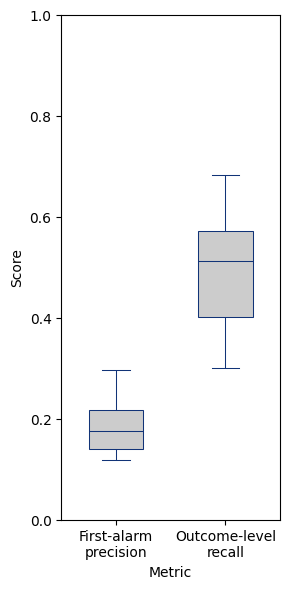

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

data = res.loc[["First-alarm precision", "Outcome-level recall"]].T

fig, ax = plt.subplots(figsize=(3, 6))
sns.boxplot(data=data, width=0.5, color=".8", linecolor="#137", linewidth=0.75, ax=ax)
# sns.stripplot(data=data, color="#137", jitter=False, size=5, marker="D", linewidth=1, alpha=.1, ax=ax)
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(["First-alarm\nprecision", "Outcome-level\nrecall"])
plt.tight_layout()
plt.savefig("/Users/kevinhe/Downloads/boxplot.png", dpi=300, bbox_inches="tight")